This example will show how to generate the Markov chain-based analysis from [1] using the MindScoPy package

In [1]:
import mindscopy as ms
from preprocessing.artifact_removal import peak_rejection, riemannian_potato_rejection
from preprocessing.misc import epoch
from preprocessing.rebias import apply_rebias_to_groups
from preprocessing.feature_extraction import ScaledTangentSpace
import numpy as np
import pyriemann


In [2]:
# use sample data from study for now, will change this to BCI competition data later
import pickle
with open('B:/nicolas-ivanov_eeg-bci-metric-assesst_0545_data_prism/Processed Data/8-7s-preprocessed-epoched-bandpass-main.pickle', 'rb') as f:
    d = pickle.load(f)


Perform the preprocessing steps of artifact rejecting and sub-epoching.

In [3]:
data = d[2]
print(data.keys())
Xall = data['trials']
y = data['labels']
blocks = data['run_label']
print(Xall.shape)

dict_keys(['baseline', 'trials', 'raw_trials', 'labels', 'run_label'])
(360, 32, 1750)


In [4]:
# select channels
ch_map = {
    'FCz' : 0,
    'Fz' : 1,
    'FC3': 4,
    'C5': 6,
    'C3': 7,
    'C1': 8,
    'Cz': 9,
    'CP3': 10,
    'CPz': 11,
    'P7': 12,
    'P5': 13,
    'P3': 14,
    'P1': 15,
    'Pz': 16,
    'PO3': 17,
    'Oz': 18,
    'PO4': 19,
    'P8': 20,
    'P6': 21,
    'P4' : 22,
    'P2' : 23,
    'CP4': 24,
    'C6' : 26,
    'C4' : 27,
    'C2' : 28,
    'FC4' : 29,
}

sel_chs = np.asarray([ch_map[ch] for ch in ch_map])
X = Xall[:, sel_chs, :]

In [5]:
print(X.shape)

(360, 26, 1750)


In [6]:
# apply peak rejection
X, rejected_trials = peak_rejection(X, threshold=350, verbose=True)
y = np.delete(y, rejected_trials)
blocks = np.delete(blocks, rejected_trials)


44 trials rejected.


In [7]:
# apply riemannian potato rejection to each block of trials
clean_X = []
clean_y = []
clean_blocks = []
for block in np.unique(blocks):
    block_idx = blocks == block
    X_block = X[block_idx]
    y_block = y[block_idx]
    blocks_block = blocks[block_idx]

    X_block, rejected_trials = riemannian_potato_rejection(X_block, threshold=2.5, verbose=True)
    y_block = np.delete(y_block, rejected_trials)
    blocks_block = np.delete(blocks_block, rejected_trials)

    clean_X.append(X_block)
    clean_y.append(y_block)
    clean_blocks.append(blocks_block)

X = np.concatenate(clean_X)
y = np.concatenate(clean_y)
blocks = np.concatenate(clean_blocks)

Iteration 0: 8 trials rejected.
Iteration 1: 0 trials rejected.
Process complete, 8 total trials rejected.
Iteration 0: 12 trials rejected.
Iteration 1: 0 trials rejected.
Process complete, 12 total trials rejected.
Iteration 0: 11 trials rejected.
Iteration 1: 0 trials rejected.
Process complete, 11 total trials rejected.
Iteration 0: 5 trials rejected.
Iteration 1: 0 trials rejected.
Process complete, 5 total trials rejected.


Now compute the mean covariance matrix for each block. These will be used for rebiasing the sub-epoch covariance matrices.

In [8]:
Nt, Nc, Ns = X.shape
Nblks = len(np.unique(blocks))

# block means
block_means = np.zeros((Nblks, Nc, Nc))
for i, block in enumerate(np.sort(np.unique(blocks))):
    block_covs = pyriemann.utils.covariance.covariances(X[blocks == block])
    block_means[i] = pyriemann.utils.mean.mean_covariance(block_covs)

In [9]:
# Generate sub-epochs for each trial
Fs = 250
length = 1
stride = 0.5
Ns_epoch = int(Fs * length)
Xcluster = epoch(X, Ns_epoch, int(Fs * stride))

In [10]:
Nclust_epochs = Xcluster.shape[1]

In [11]:
# apply the rebiasing to the sub-epochs
blocks_clust_epochs = np.repeat(blocks, Xcluster.shape[1])

Xcluster = np.reshape(Xcluster, (-1, Nc, Ns_epoch))
Xclust_covs = pyriemann.utils.covariance.covariances(Xcluster)

Xclust_covs = apply_rebias_to_groups(Xclust_covs, blocks_clust_epochs, block_means)

In [12]:
y_seg = np.repeat(y, Nclust_epochs)
Xtask_covs = Xclust_covs[y_seg != 0]

In [13]:
# apply feature extraction
feature_extractor = ScaledTangentSpace().fit(Xclust_covs)
Xclust_features = feature_extractor.transform(Xclust_covs)

feature_extractor.fit(Xtask_covs)
Xtask_features = feature_extractor.transform(Xtask_covs)

In [17]:
# put the data back into trial, epoch, format
Xclust_features = np.reshape(Xclust_features, (Nt, Nclust_epochs, -1))
print(Xclust_features.shape)
Ntask_trials = np.sum(y != 0)
Xtask_features = np.reshape(Xtask_features, (Ntask_trials, Nclust_epochs, -1))


(280, 13, 351)


In [22]:
# Perform clustering and generate the trajectory sub-space
np.random.seed(42)
all_state_space = ms.Markov_State_Space(krange=range(3,8)).fit(Xclust_features, verbose=True)

# create a state space for the task data only
task_state_space = ms.Markov_State_Space(krange=range(3,8)).fit(Xtask_features, verbose=True)

Selecting the number of clusters using prediction strength.
Number of clusters selected: 6
Selecting the number of clusters using prediction strength.
Number of clusters selected: 5


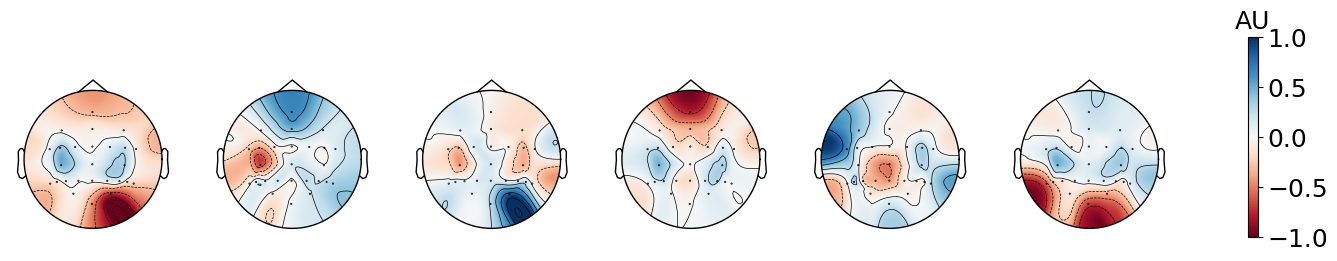

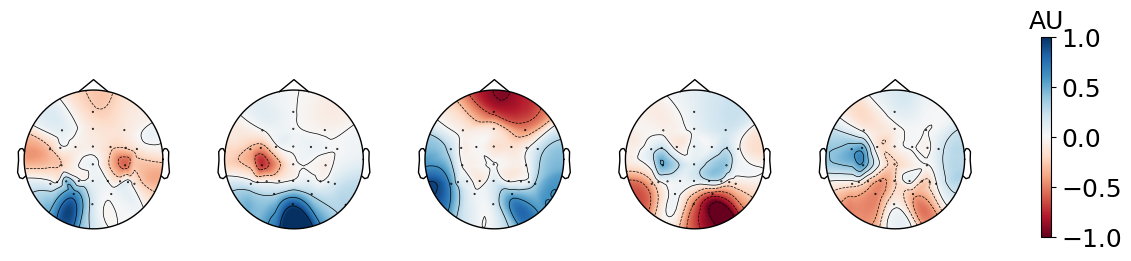

In [19]:
# visulize the pattern state activation patterns
all_state_space.plot_state_activation_patterns(np.reshape(Xclust_features, (-1, Xclust_features.shape[-1])), Xclust_covs, list(ch_map.keys()))
task_state_space.plot_state_activation_patterns(np.reshape(Xtask_features, (-1, Xtask_features.shape[-1])), Xtask_covs, list(ch_map.keys()))

In [20]:
# create Markov State Transition Matrix for each task
ytask = y[y != 0]
labels = np.unique(ytask)
models = [None] * len(labels)
for i, label in enumerate(labels):
    Xlabel = Xtask_features[ytask == label]
    S = task_state_space.transform(Xlabel)
    print(S.shape)
    models[i] = ms.Markov_Model(task_state_space).fit(np.reshape(S, (-1, Nclust_epochs)), verbose=True)

(689,)
Transition matrix:
[[0.65101942 0.18063107 0.02383495 0.07917476 0.06533981]
 [0.21932203 0.67553672 0.01       0.01       0.08514124]
 [0.20965167 0.19586357 0.20275762 0.19586357 0.19586357]
 [0.16405405 0.03567568 0.02925676 0.62621622 0.1447973 ]
 [0.16966618 0.17656023 0.07314949 0.20413643 0.37648766]]
(689,)
Transition matrix:
[[0.35029028 0.17793904 0.16415094 0.15036284 0.15725689]
 [0.13657475 0.48127721 0.0883164  0.0883164  0.20551524]
 [0.13381713 0.09934688 0.49920174 0.13381713 0.13381713]
 [0.07031746 0.02507937 0.10047619 0.65338624 0.15074074]
 [0.07785714 0.10917582 0.04131868 0.18225275 0.5893956 ]]
(702,)
Transition matrix:
[[0.32450142 0.17564103 0.18240741 0.16210826 0.15534188]
 [0.069375   0.69509615 0.12875    0.04653846 0.06024038]
 [0.03984293 0.06968586 0.76104712 0.07465969 0.0547644 ]
 [0.12286325 0.09579772 0.1769943  0.43411681 0.17022792]
 [0.10662393 0.20811966 0.13368946 0.17428775 0.3772792 ]]


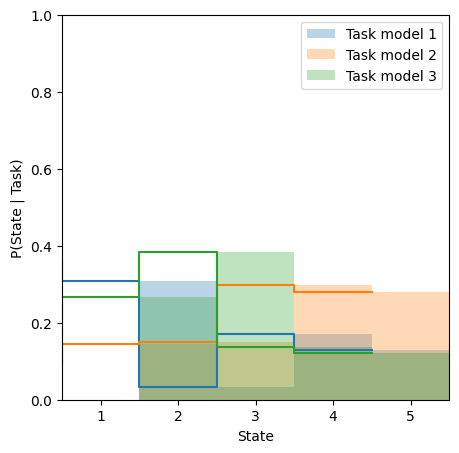

0.31159596654704025


In [21]:
# compute the taskDistinct
task_distinct = ms.task_distinct(models, visualize=True)
print(task_distinct)

In [ ]:
# create a Markov State Transition Matrix for all tasks and rest
models = [None] * (len(labels) + 1)
for i, label in enumerate(labels):
    Xlabel = Xclust_features[y == label]
    S = all_state_space.transform(Xlabel)
    models[i] = ms.Markov_Model(all_state_space).fit(np.reshape(S, (-1, Nclust_epochs)), verbose=True)
S = all_state_space.transform(Xclust_features[y == 0])
models[-1] = ms.Markov_Model(all_state_space).fit(np.reshape(S, (-1, Nclust_epochs)), verbose=True)

Transition matrix:
[[0.51987179 0.02457265 0.08141026 0.11388889 0.13012821 0.13012821]
 [0.0177552  0.60512821 0.14184809 0.04257378 0.15839381 0.03430092]
 [0.0591195  0.14184809 0.57203677 0.08393807 0.11702951 0.02602806]
 [0.14184809 0.06739236 0.13357523 0.37348815 0.14184809 0.14184809]
 [0.13771166 0.15425738 0.14598452 0.0880745  0.36935172 0.10462022]
 [0.17420635 0.05357143 0.0234127  0.04603175 0.12142857 0.58134921]]
Transition matrix:
[[0.59416667 0.01625    0.02416667 0.07166667 0.11125    0.1825    ]
 [0.0880745  0.40244315 0.1294388  0.07980164 0.17907596 0.12116594]
 [0.10875665 0.13357523 0.32385099 0.15012095 0.17493953 0.10875665]
 [0.1018626  0.06877117 0.13495404 0.39141268 0.16804548 0.13495404]
 [0.10685185 0.11388889 0.06462963 0.07166667 0.50092593 0.14203704]
 [0.13631261 0.03294473 0.01325561 0.07232297 0.11662349 0.62854059]]
Transition matrix:
[[0.38860399 0.07193732 0.0962963  0.16125356 0.12877493 0.1531339 ]
 [0.0502849  0.5537037  0.13960114 0.0502849

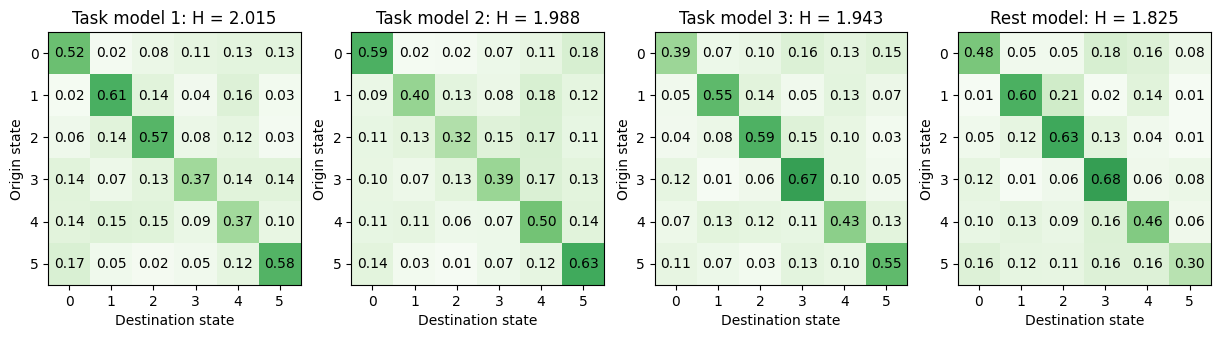

1.0556947500033196


In [ ]:
# Compute relativeTaskInconsistency
rel_task_incon = ms.relative_task_inconsistency(models[:-1], models[-1], visualize=True)
print(rel_task_incon)